In [1]:
import json
import glob
import ast
import gzip
import os
import yaml
from tqdm import tqdm
import re
from collections import defaultdict


import lightgbm as lgb
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import math
import warnings
import pickle
import time
import lightgbm as lgm
import datetime
import ast
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K


from datetime import date, time
from lightgbm import LGBMClassifier, LGBMRegressor
from pandas.plotting import scatter_matrix
from scipy import interp
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.sparse import csr_matrix, hstack

#MODELS
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2 
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, log_loss, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cross_decomposition import PLSRegression

from statsmodels.graphics.gofplots import qqplot

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

%matplotlib inline
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv("scaled_filtered_24_4_10.csv"
                )

In [3]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(df)

,Unnamed: 0,combat_id,start_time,number_of_rounds,player_ids,player_info,monsters_info,party_size,total_slots,total_max_slots,party_classes_with_level,party_total_class_composition,player_individual_hp_ratios,player_individual_ac,player_individual_prof_bonus,player_individual_strength,player_individual_dexterity,player_individual_constitution,player_individual_intelligence,player_individual_wisdom,player_individual_charisma,monster_types,monster_number,monster_total_level,party_total_level,party_level1_spellslots,party_level2_spellslots,party_level3_spellslots,party_level4_spellslots,party_level5_spellslots,party_level6_spellslots,party_level7_spellslots,party_level8_spellslots,party_level9_spellslots,party_total_ac,party_total_precombat_hp,party_total_postcombat_hp,party_total_hpratio,party_total_prof_bonus,party_total_strength,party_total_dexterity,party_total_constitution,party_total_intelligence,party_total_wisdom,party_total_charisma,player_monster_ratio,monster_player_ratio,party_max_hp,Blood Hunter,Wizard,Fighter,Paladin,Bard,Cleric,Warlock,Ranger,Barbarian,Druid,Monk,Sorcerer,Rogue,weighted_monster_level,weighted_spell_slots
0,1,1653817902-15ec25a2-6757-4ceb-ac41-d44352b97705,1.653818e+09,1,['209330647903743785'],"[{'hp_ratio': (65, 65), 'class': [('Ranger', 1...",[{'monster_id': 'c0cdb522-64c2-42ee-b1a8-6ef22...,1,"{'1': 4, '2': 3, '3': 2, '4': 0, '5': 0, '6': ...","{'1': 4, '2': 3, '3': 2, '4': 0, '5': 0, '6': ...","[('Ranger', 10)]",['Ranger'],"[(65, 65)]",[17],[4],[14],[16],[12],[12],[14],[11],['Warrior (level 4)'],1,4.00,10,4,3,2,0,0,0,0,0,0,17,65,65,1.000000,4,14,16,12,12,14,11,1.000000,1.0,65,0,0,0,0,0,0,0,1,0,0,0,0,0,4.000,139
1,14,1653869871-e7fd0606-de62-4688-a55b-ae4c25a14beb,1.653870e+09,2,['176588704091156599'],"[{'hp_ratio': (0, 38), 'class': [('Monk', 4), ...",[{'monster_id': '3bdb4cc1-6ca9-47e8-9610-d68ef...,1,"{'1': 2, '2': 0, '3': 0, '4': 0, '5': 0, '6': ...","{'1': 2, '2': 0, '3': 0, '4': 0, '5': 0, '6': ...","[('Monk', 4), ('Cleric', 1)]","['Monk', 'Cleric']","[(0, 38)]",[14],[3],[14],[16],[14],[10],[13],[13],"['Flying Sword', 'Flying Sword', 'Black Dragon...",3,2.50,5,2,0,0,0,0,0,0,0,0,14,38,0,0.000000,3,14,16,14,10,13,13,0.333333,3.0,38,0,0,0,0,0,1,0,0,0,0,1,0,0,5.000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10840,24731,1669675207-0ec4e623-552d-4d92-8788-9048a35ba79f,1.669675e+09,2,"['327601077009165698', '531204567807557136', '...","[{'hp_ratio': (21, 21), 'class': [('Rogue', 3)...",[{'monster_id': 'd2deb1dc-8ba6-4c20-8aca-e6a38...,4,"{'1': 4, '2': 5, '3': 1, '4': 0, '5': 0, '6': ...","{'1': 4, '2': 5, '3': 2, '4': 0, '5': 0, '6': ...","[('Rogue', 3), ('Druid', 5), ('Monk', 1), ('Wa...","['Rogue', 'Druid', 'Monk', 'Warlock']","[(21, 21), (24, 38), (0, 10), (27, 27)]","[15, 17, 17, 13]","[2, 3, 2, 2]","[12, 9, 7, 9]","[17, 15, 18, 12]","[12, 14, 14, 16]","[12, 15, 12, 16]","[14, 19, 17, 10]","[14, 9, 13, 19]","['Chimera', 'Pseudodragon']",2,6.25,12,4,5,1,0,0,0,0,0,0,62,96,72,0.750000,9,37,62,56,55,60,55,2.000000,0.5,96,0,0,0,0,0,0,1,0,0,1,1,0,1,9.375,141
10841,24733,1669675740-0caafbf4-7de8-46dd-a3b2-e688e22590fc,1.669676e+09,4,"['719320682668251114', '459341753590522585']","[{'hp_ratio': (11, 11), 'class': [('Fighter', ...",[{'monster_id': '640e2d82-469f-4dfe-8fb7-fb3c4...,2,"{'1': 4, '2': 1, '3': 0, '4': 0, '5': 0, '6': ...","{'1': 4, '2': 3, '3': 0, '4': 0, '5': 0, '6': ...","[('Fighter', 5), ('Cleric', 4)]","['Fighter', 'Cleric']","[(11, 11), (44, 39)]","[17, 18]","[3, 2]","[18, 16]","[15, 10]","[17, 18]","[7, 13]","[14, 20]","[14, 12]",['Succubus'],1,4.00,9,4,1,0,0,0,0,0,0,0,35,95,55,0.578947,5,34,25,35,20,34,26,2.000000,0.5,50,0,0,1,0,0,1,0,0,0,0,0,0,0,4.000,41


In [4]:
df.columns

Index(['Unnamed: 0', 'combat_id', 'start_time', 'number_of_rounds',
       'player_ids', 'player_info', 'monsters_info', 'party_size',
       'total_slots', 'total_max_slots', 'party_classes_with_level',
       'party_total_class_composition', 'player_individual_hp_ratios',
       'player_individual_ac', 'player_individual_prof_bonus',
       'player_individual_strength', 'player_individual_dexterity',
       'player_individual_constitution', 'player_individual_intelligence',
       'player_individual_wisdom', 'player_individual_charisma',
       'monster_types', 'monster_number', 'monster_total_level',
       'party_total_level', 'party_level1_spellslots',
       'party_level2_spellslots', 'party_level3_spellslots',
       'party_level4_spellslots', 'party_level5_spellslots',
       'party_level6_spellslots', 'party_level7_spellslots',
       'party_level8_spellslots', 'party_level9_spellslots', 'party_total_ac',
       'party_total_precombat_hp', 'party_total_postcombat_hp',
       '

In [5]:
df = df[['party_size',
         'monster_number',
         'party_total_ac',
         'party_total_level',
         'party_total_charisma',
         'party_max_hp',
         'party_total_strength',
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']]

## CORRELATION BASIC / MEASURES / METRICS / STATS

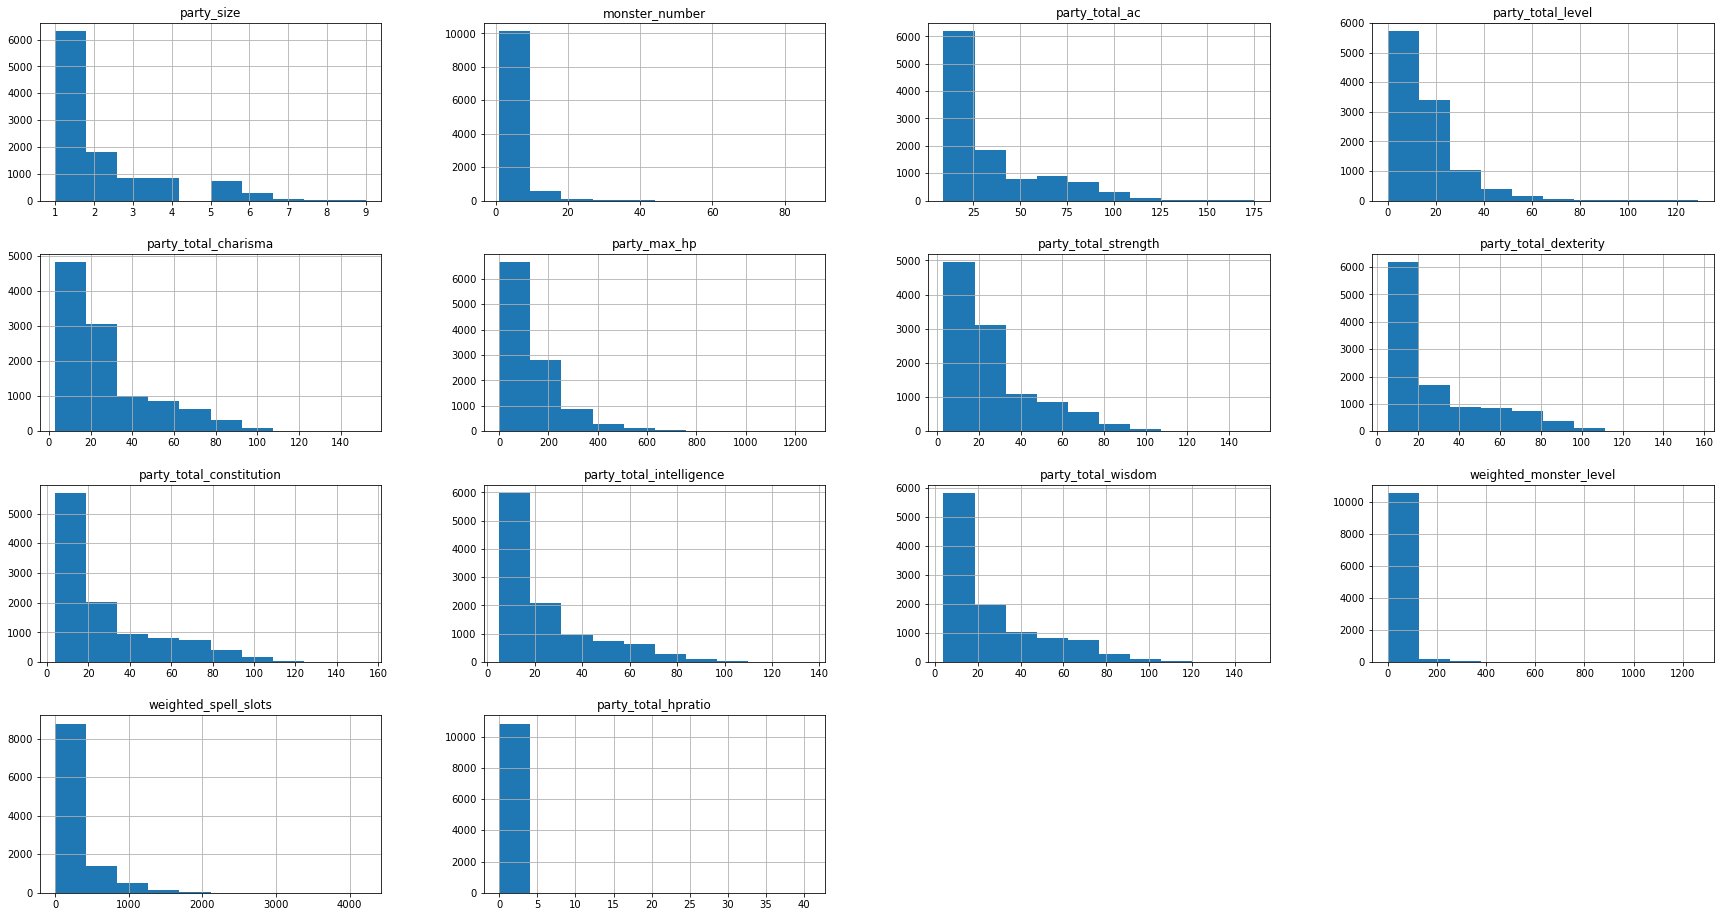

In [6]:
df.hist(figsize=(30, 16));

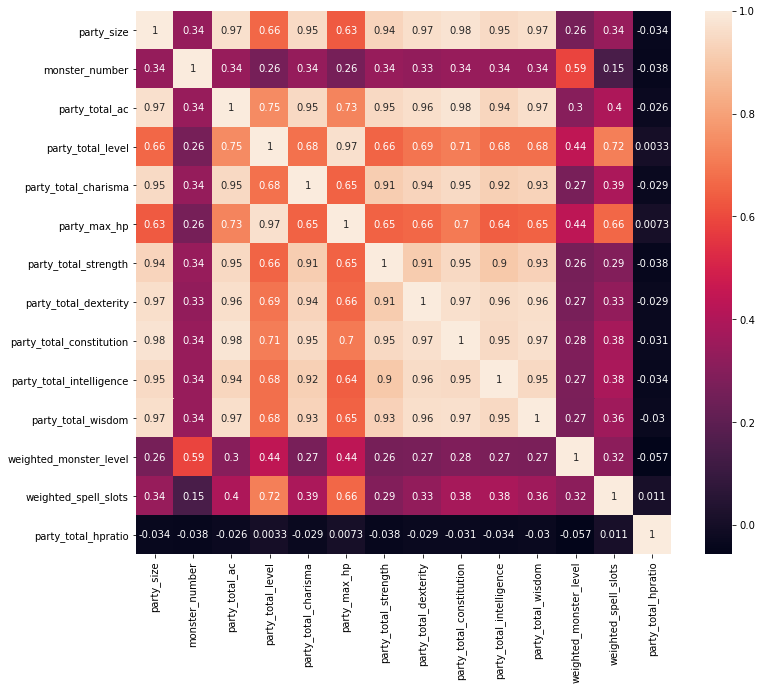

In [9]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
party_size,10842.0,1.983398,1.462346,1.0,1.000000,1.000000,3.0,9.0
monster_number,10842.0,3.114647,4.290297,1.0,1.000000,1.000000,3.0,87.0
party_total_ac,10842.0,34.272274,25.606479,9.0,17.000000,20.000000,45.0,175.0
party_total_level,10842.0,15.461354,13.025000,0.0,7.000000,12.000000,19.0,129.0
party_total_charisma,10842.0,27.191939,21.720295,3.0,12.000000,18.000000,35.0,152.0
party_max_hp,10842.0,136.534864,123.111025,1.0,56.000000,101.000000,171.0,1260.0
party_total_strength,10842.0,25.659103,20.270384,3.0,11.000000,18.000000,33.0,152.0
party_total_dexterity,10842.0,30.440878,23.106661,5.0,14.000000,19.000000,39.0,157.0
party_total_constitution,10842.0,30.856300,23.348248,4.0,14.000000,18.000000,40.0,154.0
party_total_intelligence,10842.0,24.443737,19.773699,5.0,10.000000,16.000000,32.0,136.0


In [11]:
df.head(10)

,party_size,monster_number,party_total_ac,party_total_level,party_total_charisma,party_max_hp,party_total_strength,party_total_dexterity,party_total_constitution,party_total_intelligence,party_total_wisdom,weighted_monster_level,weighted_spell_slots,party_total_hpratio
0,1,1,17,10,11,65,14,16,12,12,14,4.0,139,1.000000
1,1,3,14,5,13,38,14,16,14,10,13,5.0,12,0.000000
2,2,1,31,17,23,154,27,30,31,23,36,4.0,367,1.065421
3,2,5,31,18,23,154,27,30,31,23,36,12.0,449,0.870130
4,4,1,155,58,106,524,127,137,126,83,118,1.0,871,0.990347
5,4,7,155,58,106,524,127,137,126,83,118,5.0,871,1.000000
6,5,3,71,16,61,141,46,73,74,66,69,9.0,110,0.755725
7,3,3,46,9,42,82,31,49,45,32,34,1.5,18,0.756098
8,4,5,155,58,106,524,127,137,126,83,118,40.0,839,0.877193
9,2,1,38,29,22,332,27,34,36,25,38,4.0,24,0.672598


In [14]:
df.head(1)

,party_size,monster_number,party_total_ac,party_total_level,party_total_charisma,party_max_hp,party_total_strength,party_total_dexterity,party_total_constitution,party_total_intelligence,party_total_wisdom,weighted_monster_level,weighted_spell_slots,party_total_hpratio
0,1,1,17,10,11,65,14,16,12,12,14,4.00,139,1.00


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10842 entries, 0 to 10841
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   party_size                10842 non-null  int64  
 1   monster_number            10842 non-null  int64  
 2   party_total_ac            10842 non-null  int64  
 3   party_total_level         10842 non-null  int64  
 4   party_total_charisma      10842 non-null  int64  
 5   party_max_hp              10842 non-null  int64  
 6   party_total_strength      10842 non-null  int64  
 7   party_total_dexterity     10842 non-null  int64  
 8   party_total_constitution  10842 non-null  int64  
 9   party_total_intelligence  10842 non-null  int64  
 10  party_total_wisdom        10842 non-null  int64  
 11  weighted_monster_level    10842 non-null  float64
 12  weighted_spell_slots      10842 non-null  int64  
 13  party_total_hpratio       10842 non-null  float64
dtypes: flo

In [15]:
df.corr()['party_total_hpratio'].sort_values()

weighted_monster_level     -0.06
party_total_strength       -0.04
monster_number             -0.04
party_total_intelligence   -0.03
party_size                 -0.03
party_total_constitution   -0.03
party_total_wisdom         -0.03
party_total_dexterity      -0.03
party_total_charisma       -0.03
party_total_ac             -0.03
party_total_level           0.00
party_max_hp                0.01
weighted_spell_slots        0.01
party_total_hpratio         1.00
Name: party_total_hpratio, dtype: float64

## PYCARAT

#### Utilize PyCarat as a directional auto-generated modeling method to target possible good performing models. There are are ton of parameters you can use inside of it.

In [12]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format 
from pycaret.regression import *

In [17]:
reg_setup= setup(data = df, target = 'party_total_hpratio', html = False)

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
party_size,Categorical
monster_number,Numeric
party_total_ac,Numeric
party_total_level,Numeric
party_total_charisma,Numeric
party_max_hp,Numeric
party_total_strength,Numeric
party_total_dexterity,Numeric
party_total_constitution,Numeric
party_total_intelligence,Numeric


Setup Succesfully Completed!


,Description,Value
0,session_id,6189
1,Target,party_total_hpratio
2,Original Data,"(10842, 14)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(7589, 21)"


#### The compare models function iteratively adds one model at a time and filters the best model to the top. If you scroll to the bottom, it looks like the best models it came up with was gbr, rf, and catboost. FYI, this is a starting point, it actually doesn't build the model. Again, this is just a directional guide and each model used, we need to see what is actually happenning with paraments / tuning functions, etc.

In [18]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
lar,Least Angle Regression,40.06,28099.36,56.43,-329943.83,0.88,75.14,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
lar,Least Angle Regression,40.06,28099.36,56.43,-329943.83,0.88,75.14,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
lar,Least Angle Regression,40.06,28099.36,56.43,-329943.83,0.88,75.14,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
lar,Least Angle Regression,40.06,28099.36,56.43,-329943.83,0.88,75.14,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
par,Passive Aggressive Regressor,0.83,2.84,1.26,-20.84,0.35,1.38,0.01
lar,Least Angle Regression,40.06,28099.36,56.43,-329943.83,0.88,75.14,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
huber,Huber Regressor,0.25,0.37,0.50,-0.25,0.22,0.56,0.05
par,Passive Aggressive Regressor,0.83,2.84,1.26,-20.84,0.35,1.38,0.01
lar,Least Angle Regression,40.06,28099.36,56.43,-329943.83,0.88,75.14,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
huber,Huber Regressor,0.25,0.37,0.50,-0.25,0.22,0.56,0.05
knn,K Neighbors Regressor,0.23,0.40,0.54,-0.55,0.20,0.55,0.01
par,Passive Aggressive Regressor,0.83,2.84,1.26,-20.84,0.35,1.38,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
huber,Huber Regressor,0.25,0.37,0.50,-0.25,0.22,0.56,0.05
knn,K Neighbors Regressor,0.23,0.40,0.54,-0.55,0.20,0.55,0.01
dt,Decision Tree Regressor,0.26,0.43,0.56,-0.67,0.24,0.53,0.02


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.20,0.34,0.46,0.04,0.18,0.48,0.85
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
huber,Huber Regressor,0.25,0.37,0.50,-0.25,0.22,0.56,0.05
knn,K Neighbors Regressor,0.23,0.40,0.54,-0.55,0.20,0.55,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.20,0.34,0.46,0.04,0.18,0.48,0.85
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
et,Extra Trees Regressor,0.21,0.35,0.48,-0.08,0.19,0.49,0.54
huber,Huber Regressor,0.25,0.37,0.50,-0.25,0.22,0.56,0.05


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.20,0.34,0.46,0.04,0.18,0.48,0.85
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
et,Extra Trees Regressor,0.21,0.35,0.48,-0.08,0.19,0.49,0.54
huber,Huber Regressor,0.25,0.37,0.50,-0.25,0.22,0.56,0.05


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.21,0.33,0.46,0.07,0.18,0.49,0.25
rf,Random Forest Regressor,0.20,0.34,0.46,0.04,0.18,0.48,0.85
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
et,Extra Trees Regressor,0.21,0.35,0.48,-0.08,0.19,0.49,0.54


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.21,0.33,0.46,0.07,0.18,0.49,0.25
rf,Random Forest Regressor,0.20,0.34,0.46,0.04,0.18,0.48,0.85
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
et,Extra Trees Regressor,0.21,0.35,0.48,-0.08,0.19,0.49,0.54


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.21,0.33,0.46,0.07,0.18,0.49,0.25
rf,Random Forest Regressor,0.20,0.34,0.46,0.04,0.18,0.48,0.85
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01
lightgbm,Light Gradient Boosting Machine,0.21,0.34,0.47,-0.03,0.18,0.48,0.78


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.21,0.33,0.46,0.07,0.18,0.49,0.25
rf,Random Forest Regressor,0.20,0.34,0.46,0.04,0.18,0.48,0.85
catboost,CatBoost Regressor,0.20,0.34,0.46,0.02,0.18,0.48,1.26
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
llar,Lasso Least Angle Regression,0.23,0.34,0.47,-0.00,0.19,0.55,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.21,0.33,0.46,0.07,0.18,0.49,0.25
rf,Random Forest Regressor,0.20,0.34,0.46,0.04,0.18,0.48,0.85
catboost,CatBoost Regressor,0.20,0.34,0.46,0.02,0.18,0.48,1.26
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
dummy,Dummy Regressor,0.23,0.34,0.47,-0.00,0.19,0.55,0.01


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.21,0.33,0.46,0.07,0.18,0.49,0.25
rf,Random Forest Regressor,0.20,0.34,0.46,0.04,0.18,0.48,0.85
catboost,CatBoost Regressor,0.20,0.34,0.46,0.02,0.18,0.48,1.26
br,Bayesian Ridge,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lr,Linear Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.39
ridge,Ridge Regression,0.22,0.34,0.46,0.01,0.19,0.52,0.01
en,Elastic Net,0.22,0.34,0.46,0.01,0.19,0.53,0.01
omp,Orthogonal Matching Pursuit,0.22,0.34,0.46,0.01,0.19,0.52,0.01
lasso,Lasso Regression,0.22,0.34,0.46,0.01,0.19,0.54,0.01
dummy,Dummy Regressor,0.23,0.34,0.47,-0.00,0.19,0.55,0.01


#### Building auto-generated model here for Gradient Boosting Regressor. Folds are the different cross-validation folds

In [21]:
gbr_model = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.20,0.08,0.29,0.10,0.17,0.44
1,0.20,0.11,0.33,0.11,0.17,0.42
2,0.19,0.11,0.33,0.03,0.17,0.41
3,0.22,0.13,0.36,0.07,0.20,0.60
4,0.21,0.26,0.51,0.04,0.18,0.42
5,0.19,0.07,0.27,0.09,0.17,0.46
6,0.19,0.08,0.29,0.14,0.17,0.47
7,0.19,0.08,0.28,0.09,0.17,0.72
8,0.25,2.25,1.50,-0.02,0.22,0.40


#### Tune the model. This finds the best hyperparameters for the model.

In [23]:
tuned_gbr_model = tune_model(gbr_model, n_iter = 10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.4s finished


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.20,0.09,0.30,0.03,0.18,0.45
1,0.20,0.12,0.34,0.04,0.18,0.44
2,0.20,0.10,0.32,0.09,0.17,0.41
3,0.22,0.13,0.36,0.07,0.20,0.60
4,0.22,0.26,0.51,0.02,0.19,0.45
5,0.20,0.08,0.29,-0.04,0.18,0.48
6,0.20,0.09,0.30,0.05,0.18,0.49
7,0.20,0.08,0.28,0.10,0.17,0.77
8,0.25,2.22,1.49,-0.01,0.21,0.42


#### Visualize the errors

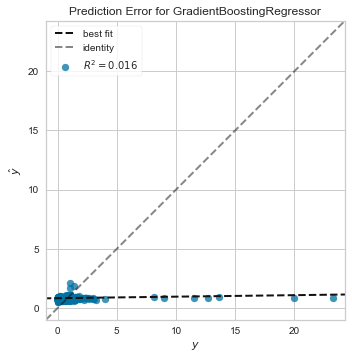

In [24]:
plot_model(tuned_gbr_model, plot = 'error')

#### Visualize Feature Importance 

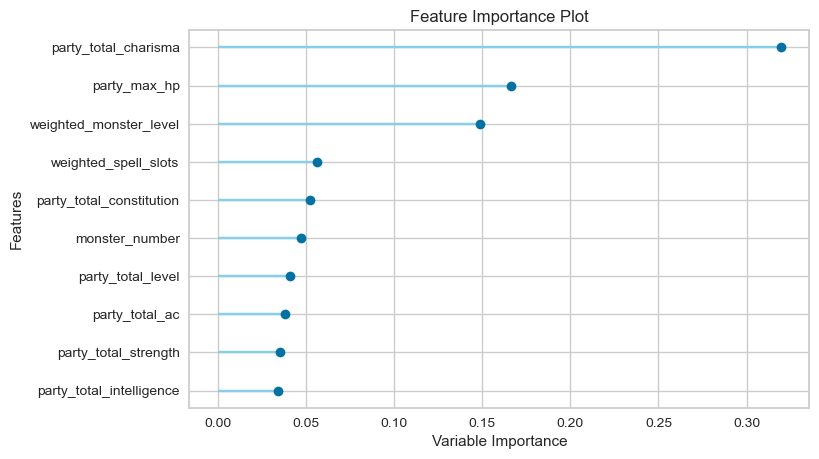

In [25]:
plot_model(tuned_gbr_model, plot='feature')

## XgBoost

In [26]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [28]:
df = df[['party_size',
         'monster_number',
         'party_total_ac',
         'party_total_level',
         'party_total_charisma',
         'party_max_hp',
         'party_total_strength',
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10842 entries, 0 to 10841
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   party_size                10842 non-null  int64  
 1   monster_number            10842 non-null  int64  
 2   party_total_ac            10842 non-null  int64  
 3   party_total_level         10842 non-null  int64  
 4   party_total_charisma      10842 non-null  int64  
 5   party_max_hp              10842 non-null  int64  
 6   party_total_strength      10842 non-null  int64  
 7   party_total_dexterity     10842 non-null  int64  
 8   party_total_constitution  10842 non-null  int64  
 9   party_total_intelligence  10842 non-null  int64  
 10  party_total_wisdom        10842 non-null  int64  
 11  weighted_monster_level    10842 non-null  float64
 12  weighted_spell_slots      10842 non-null  int64  
 13  party_total_hpratio       10842 non-null  float64
dtypes: flo

## Define X, y

In [30]:
y = df.pop('party_total_hpratio')
X = df

In [32]:
X.head(3)

,party_size,monster_number,party_total_ac,party_total_level,party_total_charisma,party_max_hp,party_total_strength,party_total_dexterity,party_total_constitution,party_total_intelligence,party_total_wisdom,weighted_monster_level,weighted_spell_slots
0,1,1,17,10,11,65,14,16,12,12,14,4.00,139
1,1,3,14,5,13,38,14,16,14,10,13,5.00,12
2,2,1,31,17,23,154,27,30,31,23,36,4.00,367


## Test Train Split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Build XgBoost Regressor Model

In [34]:
import xgboost as xgb 

parameters = {'learning_rate': [0.1], #so called `eta` value
              'max_depth': [7],
              'n_estimators': [100]}

xgb = xgboost.XGBRegressor(n_estimators=1000, 
                   max_depth=20, 
                   eta=0.4, 
                   subsample=0.7, 
                   colsample_bytree=0.8)

xgb_gridsearch = GridSearchCV(xgboost.XGBRegressor(),
                             parameters, 
                             n_jobs=-10,
                             verbose=True,
                             scoring='neg_mean_squared_error')

xgb_gridsearch.fit(X_train, y_train)

print( "best parameters:", xgb_gridsearch.best_params_ )

best_xgb_model = xgb_gridsearch.best_estimator_



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-10)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-10)]: Done   5 out of   5 | elapsed:    2.9s finished


best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [35]:
def score_model(best_xgb_model, X_train, y_train):
    MSE = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    R2 = cross_val_score(best_xgb_model, X_train, y_train, cv=5, scoring='r2').mean()
#     RMSE = cross_val_score(model, X_train, y_train, cv=5, scoring='mean_squared_error').sqrt()
#     print("Root Mean Square Error:\n")
    return -1 * MSE, R2

In [36]:
print('xgb:', score_model(best_xgb_model, X_train, y_train))

xgb: (1.2463249652020376, -7.129713010591075)


In [37]:
def score_model(xgb, X_train, y_train):
    MSE = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    R2 = cross_val_score(xgb, X_train, y_train, cv=5, scoring='r2').mean()
    return -1 * MSE, R2

In [38]:
print('xgb:', score_model(xgb, X_train, y_train))

xgb: (0.7134746323043936, -1.8381385421430299)


In [39]:
mse = mean_squared_error(y_test, best_xgb_model.predict(X_test))
rmse = mean_squared_error(y_test, best_xgb_model.predict(X_test)) ** 0.5
r2 = r2_score(y_test, best_xgb_model.predict(X_test)) 

In [40]:
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

Mean Squared Error: 0.24904400567989923
Root Mean Squared Error: 0.49904309000315716
R-squared Score: 0.02414150524642067


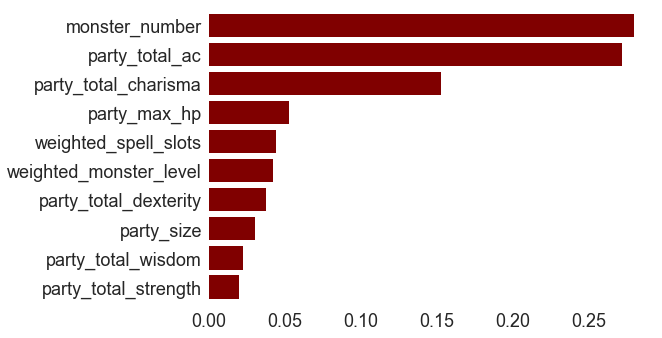

In [97]:
plt.rcParams['axes.grid'] = False
plt.rcParams["font.family"] = "Arial"
plt.box(False)

Feature_importance = pd.Series(best_xgb_model.feature_importances_, index=X.columns)
Feature_importance.nlargest(10).plot(kind='barh', color='maroon', fontsize=18, width=0.8).invert_yaxis()


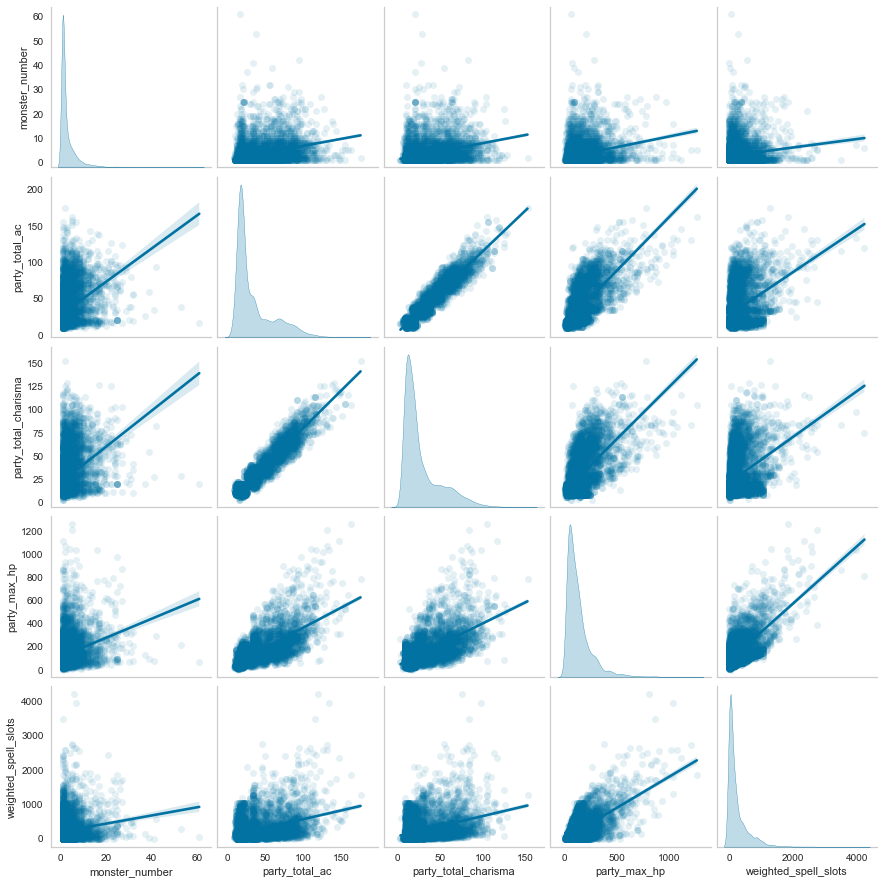

In [71]:
df = X_train.copy()
df.insert(0, "party_total_hpratio", y_train)
_ = sns.pairplot(
    df[
        ["monster_number", "party_total_ac", "party_total_charisma", "party_max_hp", "weighted_spell_slots"]
    ],
    kind="reg",
    diag_kind="kde",
    plot_kws={"scatter_kws": {"alpha": 0.1}},
)

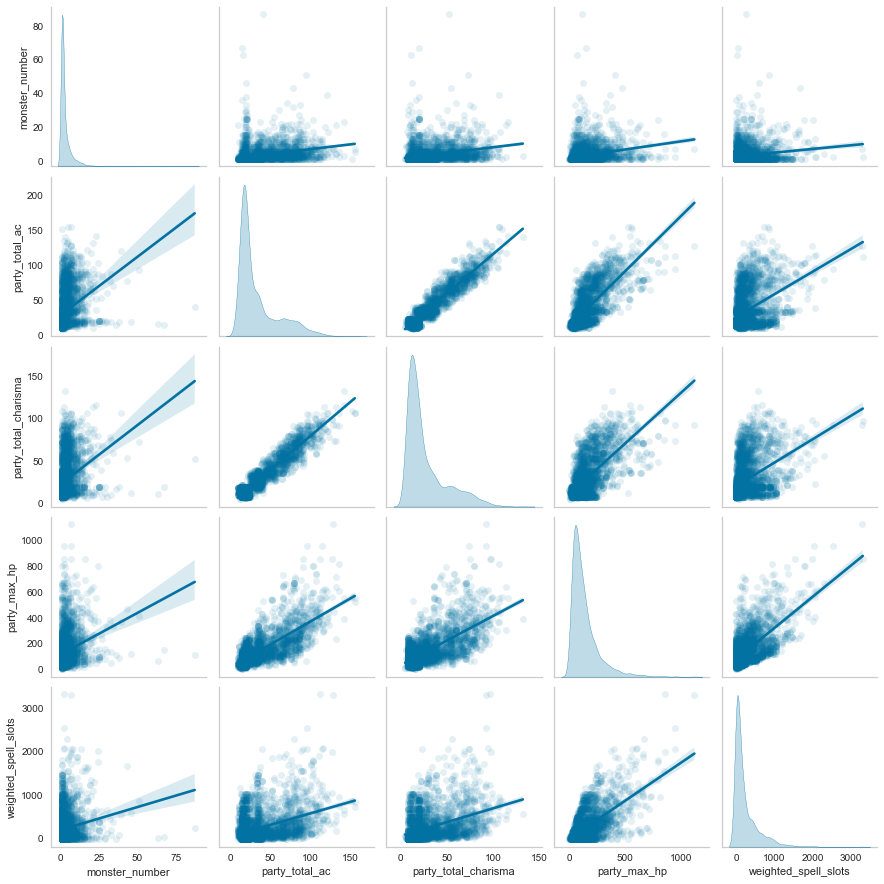

In [72]:
df = X_test.copy()
df.insert(0, "party_total_hpratio", y_test)
_ = sns.pairplot(
    df[
        ["monster_number", "party_total_ac", "party_total_charisma", "party_max_hp", "weighted_spell_slots"]
    ],
    
    kind="reg",
    diag_kind="kde",
    plot_kws={"scatter_kws": {"alpha": 0.1}},
)

In [98]:
y_hat = best_xgb_model.predict(X_test)

In [99]:
def r2(y, y_hat):
    return 1-((y-y_hat)**2).sum()/((y-y.mean())**2).sum()
def rmse(y, y_hat):
    return (((y-y_hat)**2).sum()/y.shape[0])**0.5

In [100]:
r2(y_test, y_hat), sklearn.metrics.r2_score(y_test, y_hat)

(0.02414150524642067, 0.02414150524642067)

In [145]:
xgb = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print( "best parameters:", xgb_gridsearch.best_params_ )

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",xgb_grid.best_estimator_)
print("\n The best score across ALL searched params:\n",xgb_grid.best_score_)
print("\n The best parameters across ALL searched params:\n",xgb_grid.best_params_)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   16.9s finished


[19:09:11] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[19:09:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=5,
             min_child_weight=4, missing=nan, monotone_constraints=

In [146]:
mse = mean_squared_error(y_test, best_xgb_model.predict(X_test))
rmse = mean_squared_error(y_test, best_xgb_model.predict(X_test)) ** 0.5
r2 = r2_score(y_test, best_xgb_model.predict(X_test)) 

In [147]:
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

Mean Squared Error: 0.24904400567989923
Root Mean Squared Error: 0.49904309000315716
R-squared Score: 0.02414150524642067


## AdaBoost

In [114]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [115]:
df = df[['party_size',
         'monster_number',
         'party_total_ac',
         'party_total_level',
         'party_total_charisma',
         'party_max_hp',
         'party_total_strength',
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']] 

In [116]:
y = df.pop('party_total_hpratio')
X = df

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [118]:
dtr = DecisionTreeRegressor(max_depth=10)
abr = AdaBoostRegressor(base_estimator=dtr, n_estimators=100, learning_rate=0.1, loss='linear', random_state=42)

abr.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=10,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
                 

In [119]:
y_pred = abr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.6454684002556241


In [120]:
mse = mean_squared_error(y_test, abr.predict(X_test))
rmse = mean_squared_error(y_test, abr.predict(X_test)) ** 0.5
r2 = r2_score(y_test, abr.predict(X_test)) 

In [121]:
print("adab - Mean Squared Error:", mse)
print("adab - Root Mean Squared Error:", rmse)
print("adab - R-squared Score:", r2)

adab - Mean Squared Error: 1.6454684002556241
adab - Root Mean Squared Error: 1.282758122272326
adab - R-squared Score: -5.447632866546186


## GradientBoost

In [132]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [133]:
df = df[['party_size',
         'monster_number',
         'party_total_ac',
         'party_total_level',
         'party_total_charisma',
         'party_max_hp',
         'party_total_strength',
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']]

In [134]:
y = df.pop('party_total_hpratio')
X = df

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [136]:
GBR = GradientBoostingRegressor()

gbr_grid = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]}

grid_GBR = GridSearchCV(GradientBoostingRegressor(), 
                            gbr_grid, 
                            cv = 2, 
                            n_jobs=-1,
                            verbose=True,
                            scoring='neg_mean_squared_error')
    
grid_GBR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

best_gbr_model = grid_GBR.best_estimator_

Fitting 2 folds for each of 256 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  8.6min finished


 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=10, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.1, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

 The best score across ALL searched params:
 -0.45938094647215766

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.1}


In [137]:
y_pred = best_gbr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.25615852722616966


In [138]:
mse = mean_squared_error(y_test, best_gbr_model.predict(X_test))
rmse = mean_squared_error(y_test, best_gbr_model.predict(X_test)) ** 0.5
r2 = r2_score(y_test, best_gbr_model.predict(X_test)) 

In [139]:
print("gbr - Mean Squared Error:", mse)
print("gbr - Root Mean Squared Error:", rmse)
print("gbr - R-squared Score:", r2)

gbr - Mean Squared Error: 0.25615852722616966
gbr - Root Mean Squared Error: 0.5061210598524524
gbr - R-squared Score: -0.003736163473536447


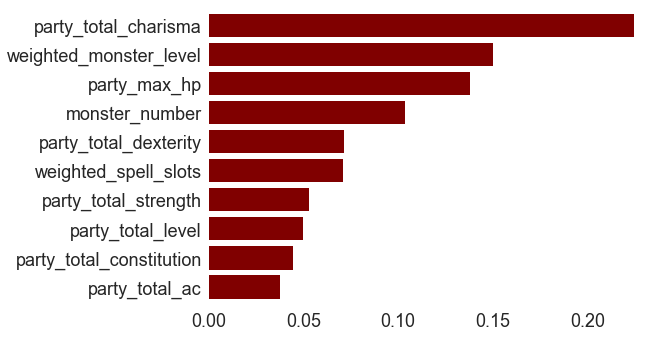

In [144]:
plt.rcParams['axes.grid'] = False
plt.rcParams["font.family"] = "Arial"
plt.box(False)

Feature_importance = pd.Series(best_gbr_model.feature_importances_, index=X.columns)
Feature_importance.nlargest(10).plot(kind='barh', color='maroon', fontsize=18, width=0.8).invert_yaxis()

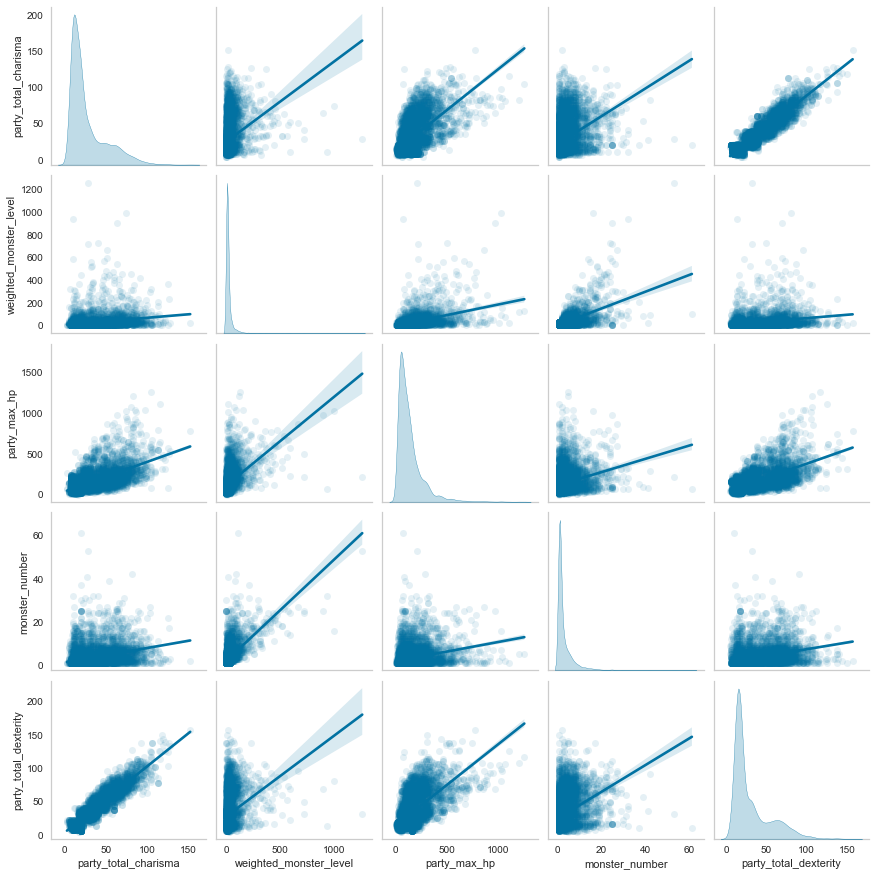

In [162]:
df = X_train.copy()
df.insert(0, "party_total_hpratio", y_train)
_ = sns.pairplot(
    df[
        ["party_total_charisma", "weighted_monster_level", "party_max_hp", "monster_number", "party_total_dexterity"]
    ],
    kind="reg",
    diag_kind="kde",
    plot_kws={"scatter_kws": {"alpha": 0.1}},
)

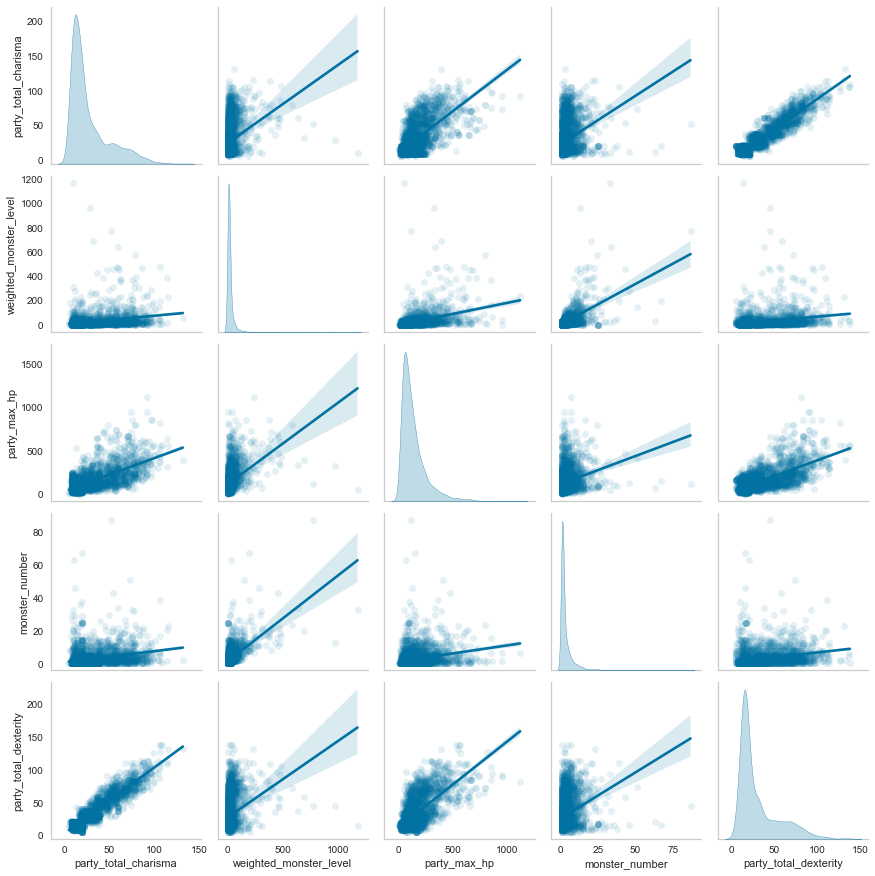

In [163]:
df = X_test.copy()
df.insert(0, "party_total_hpratio", y_test)
_ = sns.pairplot(
    df[
        ["party_total_charisma", "weighted_monster_level", "party_max_hp", "monster_number", "party_total_dexterity"]
    ],
    kind="reg",
    diag_kind="kde",
    plot_kws={"scatter_kws": {"alpha": 0.1}},
)

## Random Forrest Regressor

In [150]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [151]:
df = df[['party_size',
         'monster_number',
         'party_total_ac',
         'party_total_level',
         'party_total_charisma',
         'party_max_hp',
         'party_total_strength',
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']]

In [152]:
y = df.pop('party_total_hpratio')
X = df

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [154]:
random_forest_grid = {'max_depth': [10],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2,4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [10,20,40,80,160],
                      'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error')

rf_gridsearch.fit(X_train, y_train)

print( "best parameters:", rf_gridsearch.best_params_ )

best_rf_model = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.4min finished


best parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 160, 'random_state': 1}


In [155]:
best_rf_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=160, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [156]:
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.27002643433388673


In [157]:
mse = mean_squared_error(y_test, best_rf_model.predict(X_test))
rmse = mean_squared_error(y_test, best_rf_model.predict(X_test)) ** 0.5
r2 = r2_score(y_test, best_rf_model.predict(X_test)) 

In [158]:
print("rf - Mean Squared Error:", mse)
print("rf - Root Mean Squared Error:", rmse)
print("rf - R-squared Score:", r2)

rf - Mean Squared Error: 0.27002643433388673
rf - Root Mean Squared Error: 0.5196406780977474
rf - R-squared Score: -0.058076419198918705


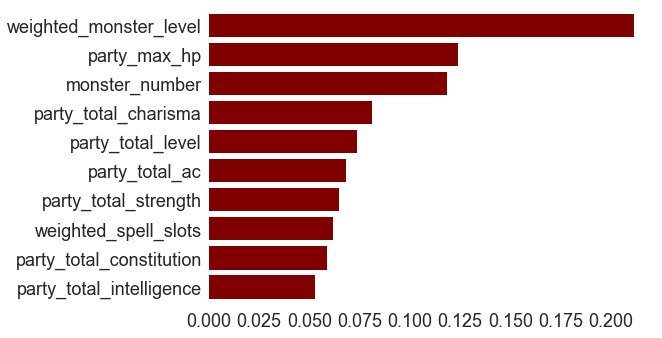

In [159]:
plt.rcParams['axes.grid'] = False
plt.rcParams["font.family"] = "Arial"
plt.box(False)

Feature_importance = pd.Series(best_rf_model.feature_importances_, index=X.columns)
Feature_importance.nlargest(10).plot(kind='barh', color='maroon', fontsize=18, width=0.8).invert_yaxis()

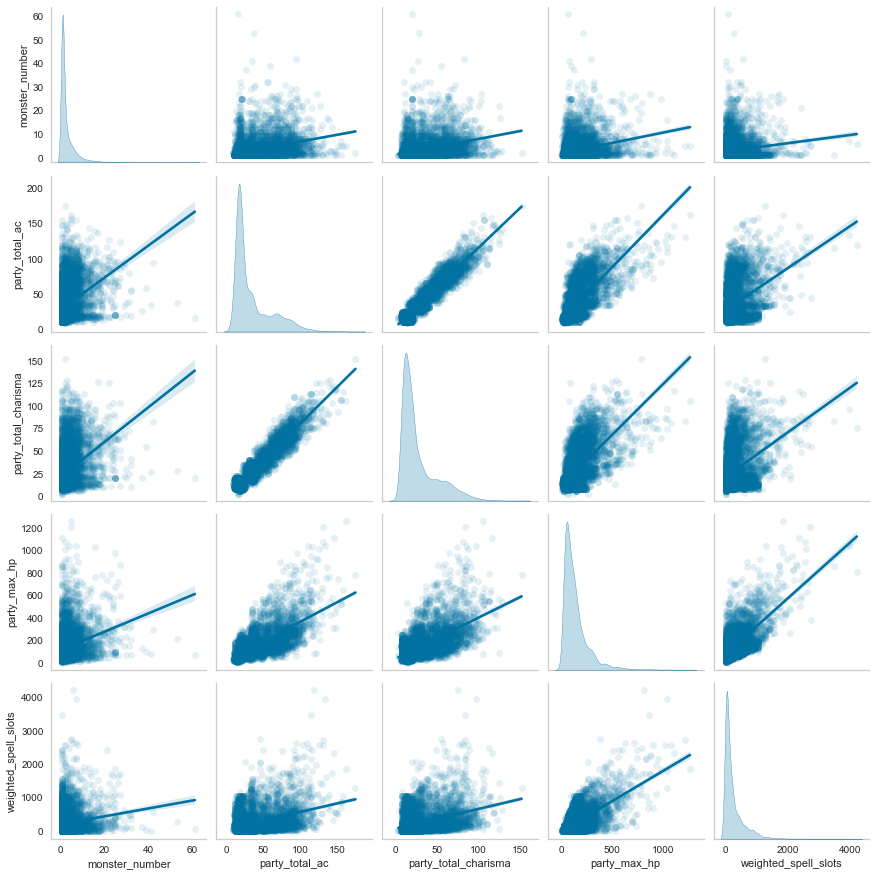

In [161]:
df = X_train.copy()
df.insert(0, "party_total_hpratio", y_train)
_ = sns.pairplot(
    df[
        ["monster_number", "party_total_ac", "party_total_charisma", "party_max_hp", "weighted_spell_slots"]
    ],
    kind="reg",
    diag_kind="kde",
    plot_kws={"scatter_kws": {"alpha": 0.1}},
)

In [ ]:
df = X_test.copy()
df.insert(0, "party_total_hpratio", y_test)
_ = sns.pairplot(
    df[
        ["party_total_charisma", "weighted_monster_level", "party_max_hp", "monster_number", "party_total_dexterity"]
    ],
    kind="reg",
    diag_kind="kde",
    plot_kws={"scatter_kws": {"alpha": 0.1}},
)

In [ ]:
df = X_test.copy()
df.insert(0, "party_total_hpratio", y_test)
_ = sns.pairplot(
    df[
        ["monster_number", "party_total_ac", "party_total_charisma", "party_max_hp", "weighted_spell_slots"]
    ],
    kind="reg",
    diag_kind="kde",
    plot_kws={"scatter_kws": {"alpha": 0.1}},

## LightGBM Regressor

In [166]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [168]:
df = df[['party_size',
         'monster_number',
         'party_total_ac',
         'party_total_level',
         'party_total_charisma',
         'party_max_hp',
         'party_total_strength',
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']]

In [169]:
y = df.pop('party_total_hpratio')
X = df

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [171]:
lgm = LGBMRegressor(learning_rate=0.1,
                                  loss='ls',
                                  n_estimators=100,
                                  random_state=1)

lgm_grid = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]}

grid_lgm = GridSearchCV(LGBMRegressor(), 
                            lgm_grid, 
                            cv = 2, 
                            n_jobs=-1,
                            verbose=True,
                            scoring='neg_mean_squared_error')

grid_lgm.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_lgm.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_lgm.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_lgm.best_params_)

best_lgm_model = grid_lgm.best_estimator_


Fitting 2 folds for each of 256 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min


 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

 The best score across ALL searched params:
 -0.4536829259205452

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.9}


[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed:  2.0min finished


In [172]:
y_pred = best_lgm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.2533586961087131


In [173]:
mse = mean_squared_error(y_test, best_lgm_model.predict(X_test))
rmse = mean_squared_error(y_test, best_lgm_model.predict(X_test)) ** 0.5
r2 = r2_score(y_test, best_lgm_model.predict(X_test)) 

In [174]:
print("lgm - Mean Squared Error:", mse)
print("lgm - Root Mean Squared Error:", rmse)
print("lgm - R-squared Score:", r2)

lgm - Mean Squared Error: 0.2533586961087131
lgm - Root Mean Squared Error: 0.5033474904166237
lgm - R-squared Score: 0.007234744950403771


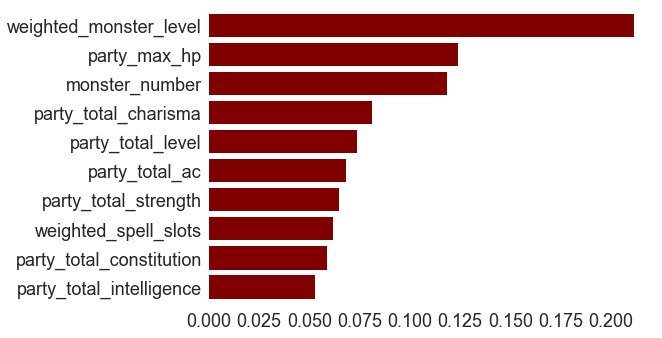

In [175]:
plt.rcParams['axes.grid'] = False
plt.rcParams["font.family"] = "Arial"
plt.box(False)

Feature_importance = pd.Series(best_rf_model.feature_importances_, index=X.columns)
Feature_importance.nlargest(10).plot(kind='barh', color='maroon', fontsize=18, width=0.8).invert_yaxis()

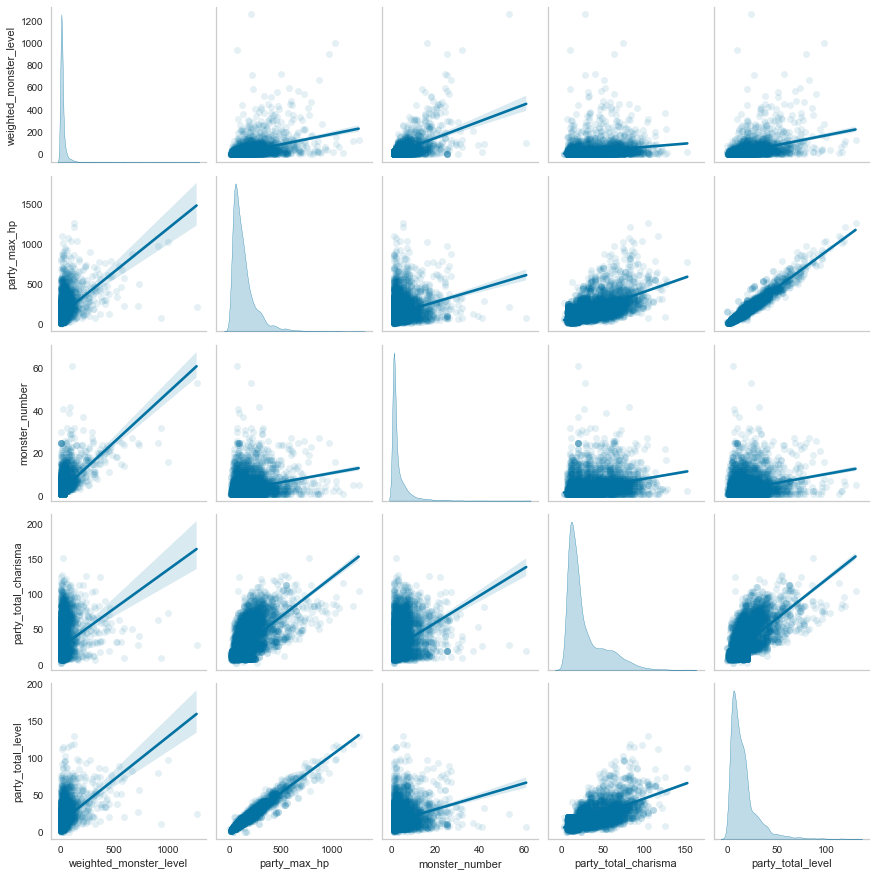

In [176]:
df = X_train.copy()
df.insert(0, "party_total_hpratio", y_train)
_ = sns.pairplot(
    df[
        ["weighted_monster_level", "party_max_hp", "monster_number", "party_total_charisma", "party_total_level"]
    ],
    kind="reg",
    diag_kind="kde",
    plot_kws={"scatter_kws": {"alpha": 0.1}},
)

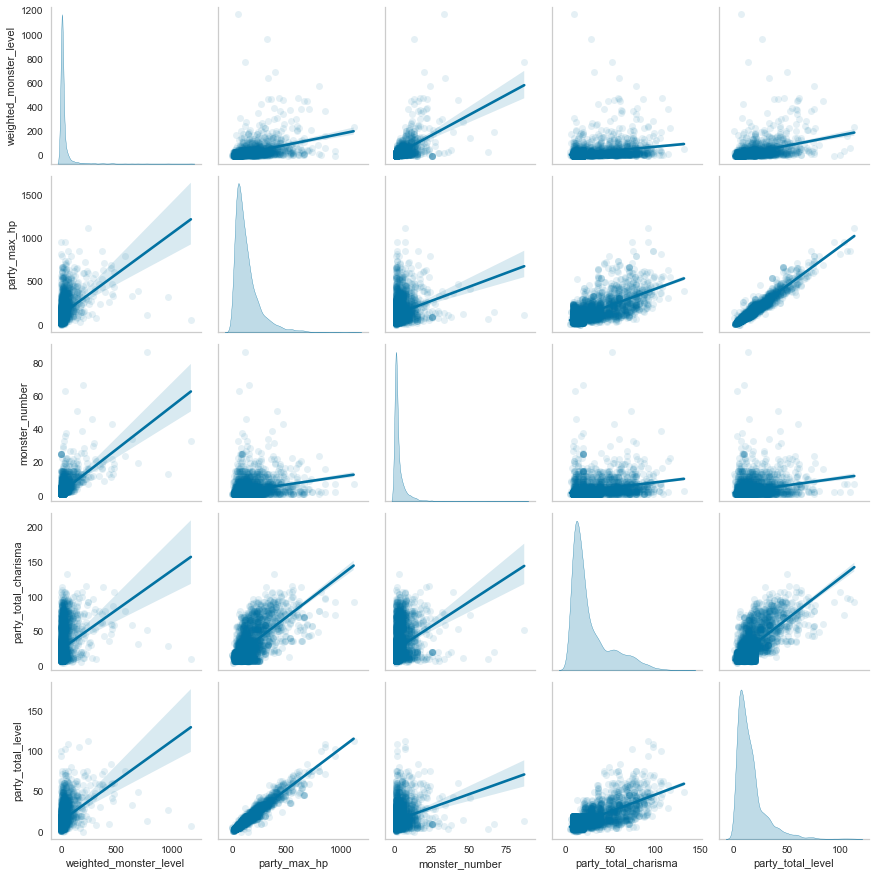

In [177]:
df = X_test.copy()
df.insert(0, "party_total_hpratio", y_test)
_ = sns.pairplot(
    df[
        ["weighted_monster_level", "party_max_hp", "monster_number", "party_total_charisma", "party_total_level"]
    ],
    kind="reg",
    diag_kind="kde",
    plot_kws={"scatter_kws": {"alpha": 0.1}},
)

## PLA Regressor

In [178]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [179]:
df = df[['party_size',
         'monster_number',
         'party_total_ac',
         'party_total_level',
         'party_total_charisma',
         'party_max_hp',
         'party_total_strength',
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']]

In [180]:
y = df.pop('party_total_hpratio')
X = df

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [182]:
# Initial PLS model fitting with a predefined number of components
pls = PLSRegression(n_components=4)
pls.fit(X_train, y_train)
Y_pred = pls.predict(X_test)

# Using KFold for cross-validation to find the optimal number of components
kf = KFold(n_splits=5, shuffle=True, random_state=42)
max_components = 20
scores = []
for i in range(1, max_components + 1):
    pls = PLSRegression(n_components=i)
    # Make sure to use X_train and y_train for cross-validation
    score = -cross_val_score(pls, X_train, y_train, cv=kf, scoring='neg_mean_squared_error').mean()
    scores.append(score)
    
optimal_components = np.argmin(scores) + 1

# Evaluation metrics for the initial model (consider re-evaluating after selecting the optimal number of components)
print(f"R-squared: {r2_score(y_test, Y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, Y_pred)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, Y_pred) ** 0.5}")
print(f"Optimal number of components based on CV: {optimal_components}")

R-squared: 0.007125553116306804
Mean Squared Error: 0.2533865624150446
Root Mean Squared Error: 0.5033751706382076
Optimal number of components based on CV: 14


## OLS

In [196]:
df = pd.read_csv("scaled_filtered_24_4_10.csv")

In [197]:
df = df[['party_size',
         'monster_number',
         'party_total_ac',
         'party_total_level',
         'party_total_charisma',
         'party_max_hp',
         'party_total_strength',
         'party_total_dexterity',
         'party_total_constitution',
         'party_total_intelligence',
         'party_total_wisdom',
         'weighted_monster_level',
         'weighted_spell_slots',
         'party_total_hpratio']]

In [198]:
y = df.pop('party_total_hpratio')
X = df

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [200]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7264, 13), (3578, 13), (7264,), (3578,))

In [201]:
result = sm.OLS(y_train, X_train).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     party_total_hpratio   R-squared (uncentered):                   0.417
Model:                             OLS   Adj. R-squared (uncentered):              0.416
Method:                  Least Squares   F-statistic:                              399.1
Date:                 Thu, 18 Apr 2024   Prob (F-statistic):                        0.00
Time:                         23:05:31   Log-Likelihood:                         -8911.5
No. Observations:                 7264   AIC:                                  1.785e+04
Df Residuals:                     7251   BIC:                                  1.794e+04
Df Model:                           13                                                  
Covariance Type:             nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
party_size                   0.3637      0.041      8.893      0.000       0.284       0.444
monster_number               0.0415      0.003     13.416      0.000       0.035       0.048
party_total_ac              -0.0017      0.003     -0.648      0.517      -0.007       0.003
party_total_level            0.0306      0.004      7.602      0.000       0.023       0.039
party_total_charisma        -0.0095      0.002     -5.762      0.000      -0.013      -0.006
party_max_hp                -0.0012      0.000     -2.977      0.003      -0.002      -0.000
party_total_strength        -0.0003      0.002     -0.152      0.879      -0.004       0.003
party_total_dexterity        0.0069      0.002      3.049      0.002       0.002       0.011
party_total_constitution     0.0032      0.003      0.950      0.342      -0.003       0.010
party_total_intelligence    -0.0164      0.002     -8.534      0.000      -0.020      -0.013
party_total_wisdom          -0.0037      0.002     -1.690      0.091      -0.008       0.001
weighted_monster_level      -0.0033      0.000    -12.823      0.000      -0.004      -0.003
weighted_spell_slots      3.694e-05   5.02e-05      0.736      0.462   -6.14e-05       0.000
==============================================================================
Omnibus:                    17202.348   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        338101152.894
Skew:                          23.464   Prob(JB):                         0.00
Kurtosis:                    1058.875   Cond. No.                     1.86e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [202]:
mse = mean_squared_error(y_test, result.predict(X_test))
rmse = mean_squared_error(y_test, result.predict(X_test)) ** 0.5
r2 = r2_score(y_test, result.predict(X_test)) 

In [203]:
print("ols - Mean Squared Error:", mse)
print("ols - Root Mean Squared Error:", rmse)
print("ols - R-squared Score:", r2)

ols - Mean Squared Error: 0.48131197616868143
ols - Root Mean Squared Error: 0.6937665141592533
ols - R-squared Score: -0.8859814725857895
